### Fraud Graphs

For today's blog we're going to discuss a **work in progress** idea I've been chewing on for a while related to ID Fraud. This is an ever growing issue for large companies, especially insurance companies and financial institutions. I've seen similar, simpler ideas implemented in the literature, but I've never seen anything as sophisticated in practice. 

There are a number of approaches to ID fraud out there. Large companeis can employ simple ruels based approaches, logistic models, gradient boosted machines, voice recognitions models (discussed in a previous post of mine), and even deep learning approaches. There is a great wealth of literature on all of these approaches out there for those interested in learning more.

Many of these approaches look at the information of a single "account" or entity and try to determine if the information is fraudulant. Some tiems this is easy. For example, a social security number that isn't registered with the Social Security Administration is msot likely a fake. Sometimes it can be much harder to find the fakes. For example, when a fraudster creates a fake identity and is able to create a real social security number (ssn) to go along with the identity. We call this realm of fraud synthetic ID fraud. 

Fraudsters make these sythetic IDs as real as possible so that it is difficult to identify if all or part of the information assocaited with the identity is fake. Building models that can detect these fake IDs based only on the ID itself is very difficult.

However, there may be a different way to approach the problem to find these IDs, and that is what I'll cover in this post. 

### Synthetic Identity Fraud

Let's dive in a bit more into the problem at hand. We are trying to detect accounts that were created for identities that don't actually exist in the real world. For example, we might see a home loan for $100k assigned the the idtentity below:

First Name: Clark <br>
Last Name: Kent <br>
SSN: 913-795-1264 <br>

However, in reality, it was a scammer named Lex Luther that applied for a recieved the money. 

But Lex Luther faces a few difficulties. Firstly, it's ahrd to create a 100 percent fake identity that has a credit score big enough to get a 100k dollar loan! Secondly, Lex needs to produce a large number of these fake IDs to use given that a) many of these IDs will be caught and shut down and 2) he needs more than 100k dollars to run his evil criminal empire. So Lex will try to scale his fake ID business.

Creating realistic IDs at scale can be done a few [different ways](https://securityintelligence.com/synthetic-identity-theft-three-ways-synthetic-identities-are-created/). One popular way is to take real information stolen from real people and mix and match it with fake data. You could take 10 real IDs and mix and match their data to get a few hundred fake IDs. 

I'll note that I'm skipping over a great many details in the interests of time, but that I think I've conveyed the gist of things.

### Similarity Scores

Looking at each of these synthetic IDs individually can be fruitless, but if we try to find common pieces of data between different IDs we might be able to find suspicious activity. For example, if we see two individuals with the exact same ssn, we might think that one or both of these IDs are actually fake!

So how do we look for accoutns that share information? We could assume that the information shared between accounts is exactly identical (or very very close) and look only for these exact matches. 

[Hashing](https://medium.com/smyte/streaming-similarity-search-for-fraud-detection-64d7476953d4) is an easy way to look for these similarities. There is a wealth of information about how to implement this of various fraud and cyber security problems. It is easy to build out and scales with constant time. Basically each piece of information is given a unique value in a hash and whenever one hash collides with another the we have found two pieces of information that match. 

For example: <br>
'absd' -> hash function -> 0101101 (match!) <br>
'abfd' -> hash function -> 0101111 <br>
'absd' -> hash function -> 0101101 (match!) <br>
'absb' -> hash function -> 0000101 <br>

However, it makes some pretty strict assumptions. Looking for exact or near exact matches is super restrictive. What if the fraudster randomly changes one vowel in every pieces of information in every ID he/she makes? Suddenly the hashing technique starts missing matches. There have been many efforts to make hashing more forgiving on near-exact matches (fuzzy matches), but if we don't care about executing operations in constant time, there is a more flexible alternative.

### Edit/Levenstein distance

[Edit distance](https://en.wikipedia.org/wiki/Levenshtein_distance) is a really cool way of comparing two strings. It counts the number of tiems one string needs to be edited (e.g. how many characters need to be changed) for one string to match the other. 

For example: <br>
String One: 'apple' <br>
String Two: 'apples' <br>
Edit Distance = 1 <br>

There are a few interesting variations of edit distance,b ut we'll keep it simple here. For those interested, here is a cool guide on implementing edit distance: [Wikibook Edit Distance in Multiple Computer Languages](https://en.wikibooks.org/wiki/Algorithm_Implementation/Strings/Levenshtein_distance)

BSo how will we use edit distance? We'll compare every piece of information for every ID in our dataset to every other piece of information. This will give us a list of edit distances for first names, last names, social security numbers, etc. We can then use this is a number of different ways.

1) We could build a generative model to identify the join probability of having a first name, last name, and ssn a certain edit distance away from another identity. For example: what is the probability that my first name, last name, and ssn are all exactly 1 edit distance away from another person's? That probability can then be used to find potentially fake IDs or even as an input to another model used to detect fraud. 

2) We could build a graph where IDs are the nodes and the edges are proportional to the mean edit distance of each piece of information for the ID and every other ID. Tight clsuters of IDs probably represent clusters of fake IDs generated by a fraudster.

3) We could forget fraud and use this information to find IDs belonging to family mambers sharing a last name, couples that don't share a name but cohabitate, etc. This could be valuable for marketing purposes. 

### A Simple Example

Let's work through a very very simple example of this idea. We will first generate some fake data to work with. Then we will find the edit distance between all of our samples. Finally we will look a the joint distribution of diastances in our data.

**Notes:**

There are a number of packages out there for generating fake data. I sued this code to generate fake names: https://github.com/treyhunner/names

I've built out the code to find edit distances in java to speed things up. In python this code would take forever to run! The exact implementation I used in java is based on this article: https://www.python-course.eu/levenshtein_distance.php

In [6]:
# import the packages we need
import numpy as np
import pandas as pd
from os.path import abspath, join, dirname
import random
import matplotlib.pyplot as plt

In [2]:
# create fake data 

def get_name(filename):
    selected = random.random() * 90
    with open(filename) as name_file:
        for line in name_file:
            name, _, cummulative, _ = line.split()
            if float(cummulative) > selected:
                return name
    return ""

n = 10000
first_names = []
last_names = []
ssn = []

for i in range(n):
    if np.random.rand() >= 0.5:
        name = get_name("./name_data/dist.male.first")
        first_names.append(name)
    else:
        name = get_name("./name_data/dist.female.first")
        first_names.append(name)
    
    name = get_name("./name_data/dist.all.last")
    last_names.append(name)
    
    a = str(random.randint(0, 9999999999)).zfill(10)
    ssn.append(a)
    
df = pd.DataFrame()
df['last_names'] = last_names
df['first_names'] = first_names
df['ssn'] = ssn
df.to_csv('./name_data/names.csv', index=False)

df.head()

,last_names,first_names,ssn
0,TALIB,GLEN,8745036100
1,DUNN,BLAINE,0083242992
2,GOSSER,LYNN,8485032682
3,HIGDON,KATE,6813292244
4,MILTON,MARY,8923205966


In [5]:
! java -jar Build.jar

In [7]:
df_first = pd.read_csv("./name_data/outputs/first_names_output.csv")
df_last = pd.read_csv("./name_data/outputs/last_names_output.csv")
df_ssn = pd.read_csv("./name_data/outputs/ssn_output.csv")

In [8]:
df_first.head()

,value_pair_first_names,first_names_distance
0,GLEN@BLAINE,4
1,GLEN@LYNN,3
2,GLEN@KATE,4
3,GLEN@MARY,4
4,GLEN@EDWIN,4


In [13]:
df = df_first.join(df_last, how='outer').join(df_ssn, how='outer')

In [16]:
df.head()

,value_pair_first_names,first_names_distance,value_pair_last_names,last_names_distance,value_pair_ssn,ssn_distance
0,GLEN@BLAINE,4,TALIB@DUNN,5,8745036100@0083242992,10
1,GLEN@LYNN,3,TALIB@GOSSER,6,8745036100@8485032682,6
2,GLEN@KATE,4,TALIB@HIGDON,6,8745036100@6813292244,10
3,GLEN@MARY,4,TALIB@MILTON,5,8745036100@8923205966,9
4,GLEN@EDWIN,4,TALIB@MUNDELL,7,8745036100@7860589694,8


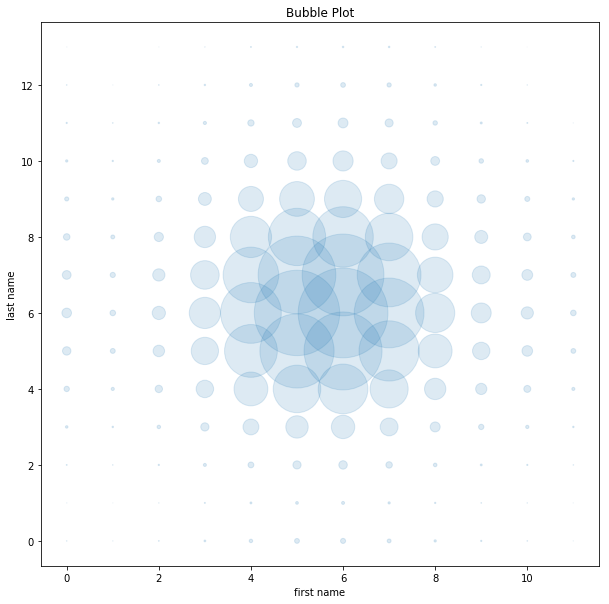

In [22]:
a = df.groupby(['first_names_distance','last_names_distance'])['value_pair_first_names'].count()
a = a.reset_index()
a['counts'] = a['value_pair_first_names']
a['percents'] = 1.0 * a.counts / a.counts.sum()

plt.figure(figsize=(10,10))
plt.scatter(a.first_names_distance,a.last_names_distance,s=100000*a.percents,alpha=.15)
plt.xlabel("first name")
plt.ylabel("last name")
plt.title("Bubble Plot")
plt.show()

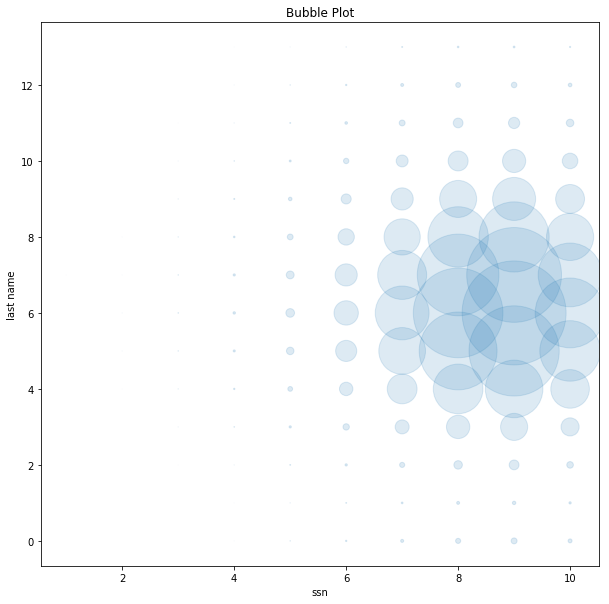

In [21]:
a = df.groupby(['ssn_distance','last_names_distance'])['value_pair_first_names'].count()
a = a.reset_index()
a['counts'] = a['value_pair_first_names']
a['percents'] = 1.0 * a.counts / a.counts.sum()

plt.figure(figsize=(10,10))
plt.scatter(a.ssn_distance,a.last_names_distance,s=100000*a.percents,alpha=.15)
plt.xlabel("ssn")
plt.ylabel("last name")
plt.title("Bubble Plot")
plt.show()

So what do we make of our distributions? (for those unfamiliar with [bubble charts](https://en.wikipedia.org/wiki/Bubble_chart))

Firstly, it is very unlikely to have a last name and ssn that have very low edit distances. This makes sense since individuals that share last naems tend to be family and there is no reason family should have very similar social security numbers (at least in modern times). 

We also see that it's much more common to share a first name than a last name! (No surprise there I hope)

### Last Thoughts

This post has been a very rough sketch of a work in progress model I've been thinking about for a couple years. I think that as fraud becoems more sophisticated and continues to grow as a concern for major corporations, there will be considerable more appetite for fraud detection methodologies like this one.

I hope you enjoyed this post, keep an eye out for more to come!